In [62]:
# coding: utf-8
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import torch.nn.functional as F


class lstm_model(nn.Module):
    def __init__(self, vocab, hidden_size, num_layers, dropout=0.5):
        super(lstm_model, self).__init__()
        self.vocab = vocab  # 字符数据集
        # 索引，字符
        self.int_char = {i: char for i, char in enumerate(vocab)}
        self.char_int = {char: i for i, char in self.int_char.items()}
        # 对字符进行one-hot encoding
        self.encoder = OneHotEncoder(sparse=True).fit(vocab.reshape(-1, 1))

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # lstm层
        self.lstm = nn.LSTM(len(vocab), hidden_size, num_layers, batch_first=True, dropout=dropout)

        # 全连接层
        self.linear = nn.Linear(hidden_size, len(vocab))

    def forward(self, sequence, hs=None):
        out, hs = self.lstm(sequence, hs)  # lstm的输出格式（batch_size, sequence_length, hidden_size）
        out = out.reshape(-1, self.hidden_size)  # 这里需要将out转换为linear的输入格式，即（batch_size * sequence_length, hidden_size）
        output = self.linear(out)  # linear的输出格式，(batch_size * sequence_length, vocab_size)
        return output, hs

    def onehot_encode(self, data):  # 对数据进行编码
        return self.encoder.transform(data)

    def onehot_decode(self, data):  # 对数据进行解码
        return self.encoder.inverse_transform(data)

    def label_encode(self, data):  # 对标签进行编码
        return np.array([self.char_int[ch] for ch in data])

    def label_decode(self, data):  # 对标签进行解码
        return np.array([self.int_char[ch] for ch in data])



In [63]:
def get_batches(data, batch_size, seq_len):
    '''
    :param data: 源数据，输入格式(num_samples, num_features)
    :param batch_size: batch的大小
    :param seq_len: 序列的长度（精度）
    :return: （batch_size, seq_len, num_features）
    '''
    num_features = data.shape[1]
    num_chars = batch_size * seq_len  # 一个batch_size的长度

    num_batches = int(np.floor(data.shape[0] / num_chars))  # 计算出有多少个batches

    need_chars = num_batches * num_chars  # 计算出需要的总字符量

    targets = np.vstack((data[1:].A, data[0].A))  # 可能版本问题，取成numpy比较好reshape

    inputs = data[:need_chars].A.astype("int")  # 从原始数据data中截取所需的字符数量need_words
    targets = targets[:need_chars]

    targets = targets.reshape(batch_size, -1, num_features)
    inputs = inputs.reshape(batch_size, -1, num_features)

    for i in range(0, inputs.shape[1], seq_len):
        x = inputs[:, i: i+seq_len]
        y = targets[:, i: i+seq_len]
        yield x, y  # 节省内存



In [64]:
def train(model, data, batch_size, seq_len, epochs, lr=0.01, valid=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = model.to(device)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=0.5)
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    criterion = nn.CrossEntropyLoss()

    if valid is not None:
        data = model.onehot_encode(data.reshape(-1, 1))
        valid = model.onehot_encode(valid.reshape(-1, 1))
    else:
        data = model.onehot_encode(data.reshape(-1, 1))

    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        model.train()
        hs = None  # hs等于hidden_size隐藏层节点
        train_ls = 0.0
        val_ls = 0.0
        for x, y in get_batches(data, batch_size, seq_len):
            optimizer.zero_grad()
            x = torch.tensor(x).float().to(device)
            out, hs = model(x, hs)
            hs = ([h.data for h in hs])
            y = y.reshape(-1, len(model.vocab))
            y = model.onehot_decode(y)
            y = model.label_encode(y.squeeze())
            y = torch.from_numpy(y).long().to(device)
            loss = criterion(out, y.squeeze())
            loss.backward()
            optimizer.step()
            train_ls += loss.item()

        if valid is not None:
            model.eval()
            hs = None
            with torch.no_grad():
                for x, y in get_batches(valid, batch_size, seq_len):
                    x = torch.tensor(x).float().to(device)  # x为一组测试数据，包含batch_size * seq_len个字
                    out, hs = model(x, hs)

                    # out.shape输出为tensor[batch_size * seq_len, vocab_size]
                    hs = ([h.data for h in hs])  # 更新参数

                    y = y.reshape(-1, len(model.vocab))  # y.shape为(128,100,43)，因此需要转成两维，每行就代表一个字了，43为字典大小
                    y = model.onehot_decode(y)  # y标签即为测试数据各个字的下一个字，进行one_hot解码，即变为字符
                    # 但是此时y 是[[..],[..]]形式
                    y = model.label_encode(y.squeeze())  # 因此需要去掉一维才能成功解码
                    # 此时y为[12...]成为一维的数组，每个代表自己字典里对应字符的字典序
                    y = torch.from_numpy(y).long().to(device)

                    # 这里y和y.squeeze()出来的东西一样，可能这里没啥用，不太懂
                    loss = criterion(out, y.squeeze())  # 计算损失值
                    val_ls += loss.item()

            val_loss.append(np.mean(val_ls))
        train_loss.append(np.mean(train_ls))
        print("train_loss:", train_ls)

    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val loss")
    plt.title("loop vs epoch")
    plt.legend()
    plt.show()

    model_name = "lstm_model.net"

    with open(model_name, 'wb') as f:  # 训练完了保存模型
        torch.save(model.state_dict(), f)


In [65]:
def predict(model, char, top_k=None, hidden_size=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()  # 固定参数
    with torch.no_grad():
        char = np.array([char])  # 输入一个字符，预测下一个字是什么，先转成numpy
        char = char.reshape(-1, 1)  # 变成二维才符合编码规范
        char_encoding = model.onehot_encode(char).A  # 对char进行编码，取成numpy比较方便reshape
        char_encoding = char_encoding.reshape(1, 1, -1)  # char_encoding.shape为(1, 1, 43)变成三维才符合模型输入格式
        char_tensor = torch.tensor(char_encoding, dtype=torch.float32)  # 转成tensor
        char_tensor = char_tensor.to(device)

        out, hidden_size = model(char_tensor, hidden_size)  # 放入模型进行预测，out为结果

        probs = F.softmax(out, dim=1).squeeze()  # 计算预测值,即所有字符的概率

        if top_k is None:  # 选择概率最大的top_k个
            indices = np.arange(vocab_size)
        else:
            probs, indices = probs.topk(top_k)
            indices = indices.cpu().numpy()
        probs = probs.cpu().numpy()

        char_index = np.random.choice(indices, p=probs/probs.sum())  # 随机选择一个字符索引作为预测值
        char = model.int_char[char_index]  # 通过索引找出预测字符

    return char, hidden_size


In [66]:
def sample(model, length, top_k=None, sentence="c"):
    hidden_size = None
    new_sentence = [char for char in sentence]
    for i in range(length):
        next_char, hidden_size = predict(model, new_sentence[-1], top_k=top_k, hidden_size=hidden_size)
        new_sentence.append(next_char)
    return "".join(new_sentence)


train_loss: 17.488348722457886
train_loss: 15.302414655685425
train_loss: 14.863198280334473
train_loss: 14.803853750228882
train_loss: 14.772706508636475
train_loss: 14.766765594482422
train_loss: 14.745341300964355
train_loss: 14.741189002990723
train_loss: 14.733407735824585
train_loss: 14.734067678451538
train_loss: 14.731269121170044
train_loss: 14.73129391670227
train_loss: 14.730981349945068
train_loss: 14.73002290725708
train_loss: 14.730547428131104


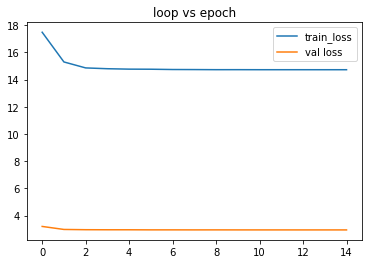

caaiatt taeie  iete   ita iatiti  i iiaeitie ete  teeea tat  t t i e  eeie  iea  ietiaa  i t  i ti it


In [67]:
def main():
    hidden_size = 512
    num_layers = 2
    batch_size = 128
    seq_len = 100
    epochs = 15
    lr = 0.01

    f = pd.read_csv("dataset/dev.tsv", sep="\t", header=None)
    f = f[0]
    text = list(f)
    text = ".".join(text)
    vocab = np.array(sorted(set(text)))  # 建立字典
    vocab_size = len(vocab)

    val_len = int(np.floor(0.2 * len(text)))  # 划分训练测试集
    trainset = np.array(list(text[:-val_len]))
    validset = np.array(list(text[-val_len:]))

    model = lstm_model(vocab, hidden_size, num_layers)  # 模型实例化
    train(model, trainset, batch_size, seq_len, epochs, lr=lr, valid=validset)  # 训练模型
    model.load_state_dict(torch.load("lstm_model.net"))  # 调用保存的模型
    new_text = sample(model, 100, top_k=5)  # 预测模型，生成100个字符,预测时选择概率最大的前5个
    print(new_text)  # 输出预测文本


if __name__ == "__main__":
    main()
